In [2]:
%reload_ext autoreload
%autoreload 2

from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
    custom_plots,
    compress_repeated_epochs
)
from ripple_heterogeneity.readout import assembly_multi_region, assembly_multi_region_member_psth
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
import os
from statannot import add_stat_annotation
from statannotations.Annotator import Annotator
import glob
import pickle
import itertools
# from scipy.stats import zscore
from scipy import stats

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [29]:
# save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_20ms_dt_sleep_compress_v2"
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt_v2"

sessions = glob.glob(save_path + os.sep + "*.pkl")
sessions_df = pd.DataFrame()
sessions_df["basepath"] = sessions

In [32]:
# save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_member_psth_v2"
# save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_member_psth_v3"
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_member_psth_v4"

batch_analysis.run(
    sessions_df,
    save_path,
    assembly_multi_region_member_psth.run,
    parallel=True,
    skip_if_error=False,
    verbose=True,
)

ccgs, label_df = assembly_multi_region_member_psth.load_results(save_path)

100%|██████████| 125/125 [14:20<00:00,  6.89s/it]


In [33]:
# ccgs.to_pickle(r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_member_psth_v2\results\ccgs.pkl")
# label_df.to_pickle(r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_member_psth_v2\results\label_df.pkl")
ccgs.to_pickle(r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_member_psth_v4\results\ccgs.pkl")
label_df.to_pickle(r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_member_psth_v4\results\label_df.pkl")


In [39]:
# ccgs_zscore = ccgs.apply(zscore)
ccgs_zscore = stats.zscore(ccgs,axis=0)


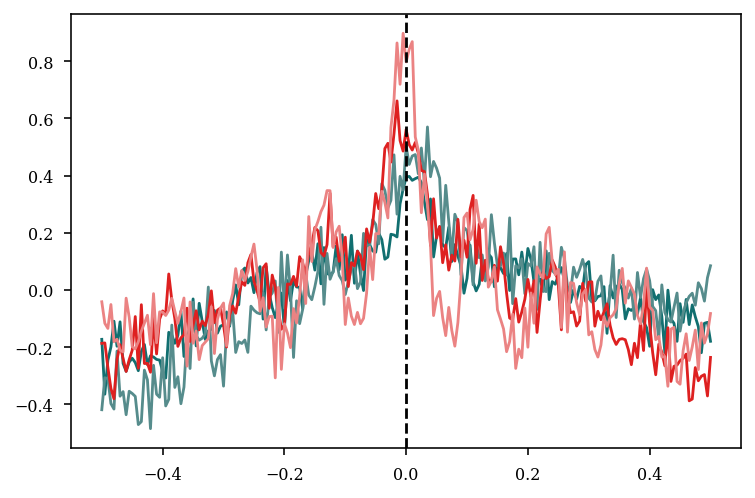

In [40]:
idx = (label_df.deepSuperficial_ref == "Deep") & (label_df.brainRegion_tar == "PFC") & (label_df.is_member_sig_ref == True) & (label_df.is_member_sig_tar == True)
ccgs_zscore.loc[:,idx].mean(axis=1).plot(color="#116f70")

idx = (label_df.deepSuperficial_ref == "Superficial") & (label_df.brainRegion_tar == "PFC") & (label_df.is_member_sig_ref == True) & (label_df.is_member_sig_tar == True)
ccgs_zscore.loc[:,idx].mean(axis=1).plot(color="#568c8c")

idx = (label_df.deepSuperficial_ref == "Deep") & (label_df.brainRegion_tar == "MEC") & (label_df.is_member_sig_ref == True) & (label_df.is_member_sig_tar == True)
ccgs_zscore.loc[:,idx].mean(axis=1).plot(color="#de2020")

idx = (label_df.deepSuperficial_ref == "Superficial") & (label_df.brainRegion_tar == "MEC") & (label_df.is_member_sig_ref == True) & (label_df.is_member_sig_tar == True)
ccgs_zscore.loc[:,idx].mean(axis=1).plot(color="#eb8383")
plt.axvline(0,linestyle="--",color="k")

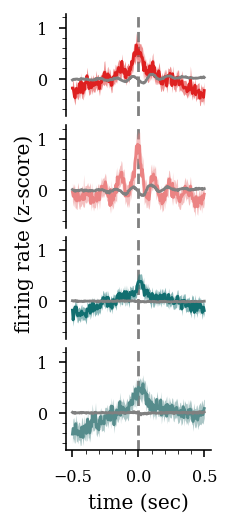

In [59]:
def confidence_intervals(X, conf=0.95):
    # remove nans
    X = X[np.sum(np.isnan(X), axis=1) == 0, :]
    # compute interval for each column
    interval = [
        stats.t.interval(conf, len(a) - 1, loc=np.mean(a), scale=stats.sem(a))
        for a in X.T
    ]
    interval = np.vstack(interval)
    lower = interval[:, 0]
    upper = interval[:, 1]
    return lower, upper

def plot_psth(
    ccgs_zscore,
    label_df,
    deepSuperficial_ref,
    brainRegion_tar,
    is_member_sig_ref,
    is_member_sig_tar,
    color,
    ax,
):
    idx = (
        (label_df.deepSuperficial_ref == deepSuperficial_ref)
        & (label_df.brainRegion_tar == brainRegion_tar)
        & (label_df.is_member_sig_ref == is_member_sig_ref)
        & (label_df.is_member_sig_tar == is_member_sig_tar)
    )
    ax.plot(ccgs_zscore.loc[:, idx].mean(axis=1), color=color)
    lower, upper = confidence_intervals(ccgs_zscore.loc[:, idx].values.T)

    ax.fill_between(
        ccgs_zscore.index,
        lower,
        upper,
        color=color,
        alpha=0.5,
        linewidth=0,
    )


fig, ax = plt.subplots(4,1,
    figsize=functions.set_size("thesis", fraction=.22, subplots=(5, 1)),
    edgecolor=None,sharey=True
)
fig.subplots_adjust(hspace=0.09, wspace=0.2)
ax = ax.ravel()

plot_psth(ccgs_zscore,label_df,"Deep","MEC",True,True,"#de2020",ax[0])
plot_psth(ccgs_zscore,label_df,"Deep","MEC",False,False,"grey",ax[0])

plot_psth(ccgs_zscore,label_df,"Superficial","MEC",True,True,"#eb8383",ax[1])
plot_psth(ccgs_zscore,label_df,"Superficial","MEC",False,False,"grey",ax[1])

plot_psth(ccgs_zscore,label_df,"Deep","PFC",True,True,"#116f70",ax[2])
plot_psth(ccgs_zscore,label_df,"Deep","PFC",False,False,"grey",ax[2])

plot_psth(ccgs_zscore,label_df,"Superficial","PFC",True,True,"#568c8c",ax[3])
plot_psth(ccgs_zscore,label_df,"Superficial","PFC",False,False,"grey",ax[3])

for i in range(4):
    ax[i].axvline(0, linestyle="--", color="grey",zorder=-1000)
    # ax[i].axvline(-0.05, linestyle="--", color="grey",zorder=-1000)
    # ax[i].axvline(0.05, linestyle="--", color="grey",zorder=-1000)

sns.despine()
# ax[0].set_ylabel("fr (z)")
# ax[2].set_ylabel("fr (z)")
ax[3].set_xlabel("time (sec)")
# ax[2].set_xlabel("time (sec)")
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[2].yaxis.set_minor_locator(AutoMinorLocator())
ax[2].xaxis.set_minor_locator(AutoMinorLocator())
ax[3].xaxis.set_minor_locator(AutoMinorLocator())


ax[0].spines["bottom"].set_visible(False)
ax[0].axes.get_xaxis().set_ticks([])

ax[1].spines["bottom"].set_visible(False)
ax[1].axes.get_xaxis().set_ticks([])

ax[2].spines["bottom"].set_visible(False)
ax[2].axes.get_xaxis().set_ticks([])

fig.text(-.15, 0.5, 'firing rate (z-score)', va='center', rotation='vertical')
plt.savefig(
    os.path.join(fig_save_path, "downstream_psth_to_ca1_assembly_members_non_members.svg"),
    dpi=300,
    bbox_inches="tight",
)

In [42]:
label_df = functions.add_animal_id(label_df)
print(label_df.query("is_member_sig_ref==True & is_member_sig_tar==True").shape)

print(label_df.query("is_member_sig_ref==True & is_member_sig_tar==True").animal_id.nunique())


(612, 13)
14


In [43]:
label_df.query("is_member_sig_ref==True & is_member_sig_tar==True").groupby("basepath").assembly_n.nunique().reset_index().assembly_n.sum()

120